In [38]:
import json
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Data Loading

In [39]:
dataset_path = "../Dataset/Regional arrival times/regional_arrival_times_1.json"

In [40]:
feature_name = "arrival_times"
naca_numbers = ['maximum_camber', 'maximum_camber_position', 'maximum_thickness']

dataset = []
with open(dataset_path, 'r') as dataset_file:
  samples = json.load(dataset_file)
  for sample in samples:
    dataset.append({
        "features": sample["features"][feature_name],
        "labels": list(sample["naca_numbers"].values())
    })

### Shuffling the dataset

In [41]:
# Shuffling the dataset
np.random.shuffle(dataset)

### Training and test set

In [42]:
# Defining the training and test set splitting percentage
split_percentage = 0.8

# Computing the number of training samples according to the splitting percentage
num_training_samples = int(np.floor(split_percentage * len(dataset)))

# Extracting the training and test set
training_set, test_set = dataset[:num_training_samples], dataset[num_training_samples:]

In [43]:
# Extracting the training features and labels
train_features = np.array([sample["features"] for sample in training_set])
train_labels = np.array([sample["labels"] for sample in training_set])

# Extracting the test features and labels
test_features = np.array([sample["features"] for sample in test_set])
test_labels = np.array([sample["labels"] for sample in test_set])

### Data normalization

In [44]:
# Computing the mean and standard deviation of the training features
mean = train_features.mean(axis=0)
std = train_features.std(axis=0)

In [45]:
# Normalizing the training and test features w.r.t. the training statistics
normalized_train_features = (train_features - mean) / std
normalized_test_features = (test_features - mean) / std

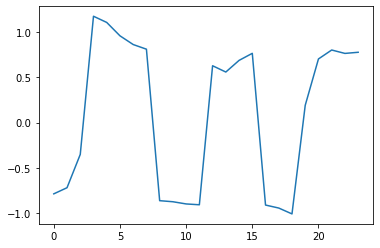

In [57]:
# Plotting a random sample
plt.plot(normalized_train_features[random.choice([0, len(normalized_train_features)-1])])
plt.show()

### Building the model

In [47]:
def buildModel():
  # Sequential Model
  model = keras.Sequential([
      keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[np.shape(normalized_train_features)[1]]),
      keras.layers.Dropout(0.05),
      keras.layers.Dense(32, activation=tf.nn.relu),
      keras.layers.Dropout(0.05),
      keras.layers.Dense(16, activation=tf.nn.relu),
      keras.layers.Dense(len(naca_numbers))
  ])

  # Compiling the model
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  
  return model

In [48]:
model = buildModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 4,259
Trainable params: 4,259
Non-trainable params: 0
____________________________________________________

### Model training

In [49]:
# Defining the number of training epochs
epochs = 200

# Early stopping with a patience of 10 epochs
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = model.fit(
    normalized_train_features, 
    train_labels,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2,
    callbacks=[early_stopping]
)

Epoch 1/200
52/52 - 1s - loss: 0.0808 - mae: 0.1970 - val_loss: 0.0277 - val_mae: 0.1092
Epoch 2/200
52/52 - 0s - loss: 0.0277 - mae: 0.1196 - val_loss: 0.0177 - val_mae: 0.0866
Epoch 3/200
52/52 - 0s - loss: 0.0197 - mae: 0.0964 - val_loss: 0.0153 - val_mae: 0.0773
Epoch 4/200
52/52 - 0s - loss: 0.0175 - mae: 0.0879 - val_loss: 0.0148 - val_mae: 0.0730
Epoch 5/200
52/52 - 0s - loss: 0.0152 - mae: 0.0803 - val_loss: 0.0124 - val_mae: 0.0662
Epoch 6/200
52/52 - 0s - loss: 0.0136 - mae: 0.0750 - val_loss: 0.0109 - val_mae: 0.0630
Epoch 7/200
52/52 - 0s - loss: 0.0122 - mae: 0.0715 - val_loss: 0.0094 - val_mae: 0.0561
Epoch 8/200
52/52 - 0s - loss: 0.0115 - mae: 0.0677 - val_loss: 0.0091 - val_mae: 0.0572
Epoch 9/200
52/52 - 0s - loss: 0.0104 - mae: 0.0643 - val_loss: 0.0081 - val_mae: 0.0529
Epoch 10/200
52/52 - 0s - loss: 0.0092 - mae: 0.0606 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 11/200
52/52 - 0s - loss: 0.0085 - mae: 0.0580 - val_loss: 0.0075 - val_mae: 0.0500
Epoch 12/200
52/52 

In [50]:
# Function to plot the metrics of training and validation
def plotHistory(history, training_metric, validation_metric, ylabel):
  plt.plot(history.history[training_metric], label=training_metric)
  plt.plot(history.history[validation_metric], label=validation_metric)
  plt.ylim([0, np.max(history.history[training_metric] + history.history[validation_metric])])
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)
  plt.show()

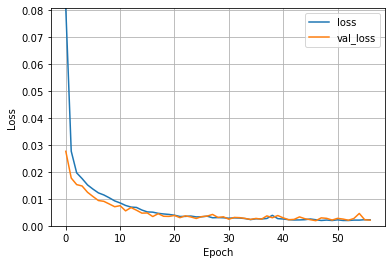

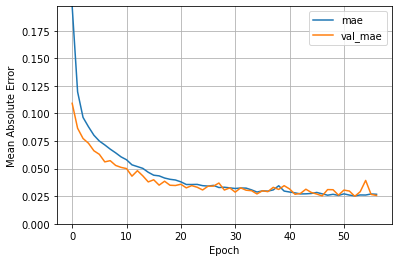

In [51]:
plotHistory(history, 'loss', 'val_loss', "Loss")
plotHistory(history, 'mae', 'val_mae', "Mean Absolute Error")

### Model evaluation

In [52]:
# Extracting the values of loss, mean absolute error and mean square error
loss, mae = model.evaluate(normalized_test_features, test_labels, verbose = 0)

print("RESULTS")
print(f"Loss (Mean Square Error) --> {loss}")
print(f"Mean Absolute Error --> {mae}")

RESULTS
Loss (Mean Square Error) --> 0.002285678405314684
Mean Absolute Error --> 0.025920426473021507


In [53]:
# Computing the predictions of the test set
predictions = model.predict(normalized_test_features)

In [54]:
# Function to plot the predicted values
def plotPredictions(test_labels, test_predictions, label, color):
  plt.scatter(test_labels, test_predictions, label=label, color=color)
  plt.xlabel('True values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.plot([0, 1], [0, 1], color="black")
  plt.legend()

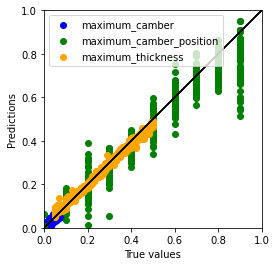

In [55]:
colors = ["blue", "green", "orange"]

# Plotting the obtained results
for i in range(len(naca_numbers)):
  plotPredictions(test_labels[:,i], predictions[:,i], label=naca_numbers[i], color=colors[i])